# Trabajo Final de Master

Este notebook contiene los códigos y desarrollos para estudiar diferentes modelos de movilidad y aplocarlos para el caso puntual de la ciudad de Bogotá

### Primera Parte. Tratamiento de datos de la encuesta de movilidad del 2019

En esta primera parte se hace un primer llamado a la encuesta de movilidad del año 2019 de Bogotá, en donde se estudiará la calidad de la fuente de datos y se crearan matrices origen destino para todos los medios de transporte, y así verificar si los datos se ajustan a diferentes modelos de movilidad urbana.

In [1]:
# Calling the libreries 
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString
from pyproj import Geod
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from numba import njit

# Declaring the paths of the trips data
trips_path = r'./Encuesta de Movilidad 2019/EODH/Archivos_CSV/ViajesEODH2019.csv'
# Path of the population data
houses_path = r'./Encuesta de Movilidad 2019/EODH/Archivos_CSV/HogaresEODH2019.csv'
# Path of the ZATs shapefiles
shape_path = r'./Encuesta de Movilidad 2019/Zonificacion_(shapefiles)/ZONAS/ZONAS/ZAT.shp'
# Path of the streets shapefile
streets_path = r'./Encuesta de Movilidad 2019/Zonificacion_(shapefiles)/Malla_Vial_Integral_Bogota_D_C/Malla_Vial_Integral_Bogota_D_C.shp'
# Path of the "Localidades" shapefile
loc_path = r'./Encuesta de Movilidad 2019/Zonificacion_(shapefiles)/loca/Loca.shp'
# Converting the CSV in a pandas dataframe
trips_df = pd.read_csv(trips_path, sep = ';')
# Converting the population data to dataframe
houses_df = pd.read_csv(houses_path, sep= ';', low_memory=False)
# Calling the ZAT's shapefile
zats_map = gpd.read_file(shape_path)
# Calling the streets shapefile
streets_map = gpd.read_file(streets_path)
# Calling the "Localidades" shapefile
loc_map = gpd.read_file(loc_path)

# Computing the centroid of each zat
zats_map['center'] = zats_map.to_crs('+proj=cea').centroid.to_crs(zats_map.crs)
zats_map = zats_map[(zats_map['MUNCod']==11001.0)|(zats_map['MUNCod']==25754.0)]

# Function which plots the place where a zat is located in Bogotá 
def one_zat(zat):
    df = zats_map[zats_map['ZAT']==zat]
    x_center = df['center'].x.iloc[0]
    y_center = df['center'].y.iloc[0]
    x_max = x_center+0.06
    x_min = x_center-0.06
    y_max = y_center+0.06
    y_min = y_center-0.06
    fig, ax = plt.subplots(1, 1, figsize=(25, 25))
    streets_map.plot(ax = ax, color='grey')
    df.plot(color='g', ax=ax)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    plt.title('ZAT number {}'.format(zat), fontsize=40)
    plt.show()

# Function which plots the zat of origin and destination of a trip
def org_dest(zat_origin, zat_destination):
    x_origin = zats_map[zats_map['ZAT'] == zat_origin ]['center'].x.iloc[0]
    x_destination = zats_map[zats_map['ZAT'] == zat_destination]['center'].x.iloc[0]
    y_origin = zats_map[zats_map['ZAT'] == zat_origin ]['center'].y.iloc[0]
    y_destination = zats_map[zats_map['ZAT'] == zat_destination]['center'].y.iloc[0]
    x_max = max([x_origin, x_destination])+0.03
    x_min = min([x_origin, x_destination])-0.03
    y_max = max([y_origin, y_destination])+0.03
    y_min = min([y_origin, y_destination])-0.03
    fig, ax = plt.subplots(1, 1, figsize=(25, 25))
    streets_map.plot(ax = ax, color='grey')
    zats_map[zats_map['ZAT'] == zat_origin ].plot(color='g', ax=ax)
    zats_map[zats_map['ZAT'] == zat_destination].plot(color='r', ax=ax)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    plt.title('ZAT of origin: {}, ZAT of destination: {}'.format(zat_origin, zat_destination), fontsize=40)
    plt.show()



Ok como una primera aproximación no se van a filtrar los datos por tiempos de viaje, ni velocidades, por lo cual, en esta primera parte se tendrán en cuenta todos los datos.
La otra cuestión es que, como me sucedio en mi TFG, el muestreo sobre los de mas municipios está mal hecho, con los datos utilizados Bojaca tendría una población mayor a Faca y eso obviamente no es congruente con la vida real y el modelo estaría incorrecto, por lo cual, de nuevo, se van a utilizar solo datos en donde los viajes sean en Bogotá o Soacha.

In [2]:
# Filtering the data in order to take only the trips in Bogotá and Soacha
trips_df = trips_df[(trips_df['mun_origen'] == 11001) | (trips_df['mun_origen'] == 25754)]
trips_df = trips_df[(trips_df['mun_destino'] == 11001) | (trips_df['mun_destino'] == 25754)]
houses_df = houses_df[(houses_df['municipio'] == 11001) | (houses_df['municipio'] == 25754)]

# Filtering the data to avoid the ZAT number 0.0
trips_df = trips_df[(trips_df['zat_origen']>0)&(trips_df['zat_destino']>0)]

In [3]:
# Computing the population per zat
population = houses_df[['zat_hogar', 'p7_total_personas']]
population = population.groupby('zat_hogar').agg('sum').sort_values(by='p7_total_personas', ascending=False)

Dado que el modelo gravitacional escala como $r^{-\alpha}$, no podemos tener en cuenta viajes dentro de una misma ZAT, por lo cual estos serán filtrados.

In [4]:
# Computing the number of trips between diferent zats 
num_trips_df = trips_df[['zat_origen', 'zat_destino']]
#num_trips_df['trips'] = np.ones(len(num_trips_df)) 
num_trips_df.loc[0:, ['trips']] = 1
num_trips_df = (num_trips_df.groupby(['zat_origen', 'zat_destino'], as_index=False)['trips']
                            .agg('sum')
                            .sort_values(by='trips', ascending=False))
num_trips_df = num_trips_df[num_trips_df['zat_destino'] != num_trips_df['zat_origen']]

Dado que el modelo gravitacional es simetrico, debemos sumar los viajes de "ida y de regreso" entre dos ZATs, por lo cual, vamos a convertir el numero de viajes en una matriz y la sumamos con su transpuesta para simetrizar esta matriz, y luego la convertimos en columna de nuevo. 

In [5]:
# Symmetrizing the number of trips between each zat
table = pd.pivot_table(num_trips_df, values='trips', index='zat_origen', columns='zat_destino').fillna(0)
table = table + table.T

sim_num_trips = (table.stack()
                      .to_frame()
                      .reset_index()
                      .rename(columns={'level_0': 'zat_origen', 'level_1': 'zat_destino', 0: 'trips'})
                      .sort_values(by='trips', ascending=False))
sim_num_trips = sim_num_trips[sim_num_trips['trips']>0]
#sim_num_trips

In [6]:
# Adding the centroid coordinates to the df

num_dis_trips = (num_trips_df.merge(zats_map[['ZAT', 'center']], left_on='zat_origen', right_on='ZAT')
                             .rename(columns={'center': 'Origin_center'})
                             .drop(columns='ZAT'))
num_dis_trips = (num_dis_trips.merge(zats_map[['ZAT', 'center']], left_on='zat_destino', right_on='ZAT')
                             .rename(columns={'center': 'Destination_center'})
                             .drop(columns='ZAT'))
#num_dis_trips.sort_values(by='trips', ascending=False)

In [7]:
# Adding the centroid coordinates to the symmetrical df

num_dis_sim = (sim_num_trips.merge(zats_map[['ZAT', 'center']], left_on='zat_origen', right_on='ZAT')
                             .rename(columns={'center': 'Origin_center'})
                             .drop(columns='ZAT'))
num_dis_sim = (num_dis_sim.merge(zats_map[['ZAT', 'center']], left_on='zat_destino', right_on='ZAT')
                             .rename(columns={'center': 'Destination_center'})
                             .drop(columns='ZAT')
                             .sort_values(by='trips', ascending=False))
num_dis_sim

zat_origen  zat_destino  trips              Origin_center  \
0           551.0        530.0  139.0  POINT (-74.18166 4.62800)   
17445       530.0        551.0  139.0  POINT (-74.17593 4.63213)   
39890       776.0        775.0  112.0  POINT (-74.19802 4.57757)   
35874       775.0        776.0  112.0  POINT (-74.19736 4.58356)   
44163       714.0       1050.0  105.0  POINT (-74.16040 4.55118)   
...           ...          ...    ...                        ...   
16125       384.0        146.0    1.0  POINT (-74.11607 4.63152)   
16127       292.0        146.0    1.0  POINT (-74.08774 4.65158)   
40609        94.0        992.0    1.0  POINT (-74.06958 4.72382)   
40610       475.0        992.0    1.0  POINT (-74.07030 4.59374)   
52982       322.0        194.0    1.0  POINT (-74.10973 4.65777)   

              Destination_center  
0      POINT (-74.17593 4.63213)  
17445  POINT (-74.18166 4.62800)  
39890  POINT (-74.19736 4.58356)  
35874  POINT (-74.19802 4.57757)  
44163  POINT (-74.15788 4.52832)  
...                          ...  
16125  POINT (-74.05197 4.70272)  
16127  POINT (-74.05197 4.70272)  
40609  POINT (-74.07096 4.61493)  
40610  POINT (-74.07096 4.61493)  
52982  POINT (-74.13858 4.71549)  

[71906 rows x 5 columns]

In [8]:
# Calculating the distances in meters
distance = []
geod = Geod(ellps = 'WGS84')
for i in range(len(num_dis_sim)):
    line = LineString([num_dis_sim['Origin_center'].iloc[i], num_dis_sim['Destination_center'].iloc[i]])
    dist = geod.geometry_length(line)
    distance.append(dist)

num_dis_sim['distance'] = distance
num_dis_sim

zat_origen  zat_destino  trips              Origin_center  \
0           551.0        530.0  139.0  POINT (-74.18166 4.62800)   
17445       530.0        551.0  139.0  POINT (-74.17593 4.63213)   
39890       776.0        775.0  112.0  POINT (-74.19802 4.57757)   
35874       775.0        776.0  112.0  POINT (-74.19736 4.58356)   
44163       714.0       1050.0  105.0  POINT (-74.16040 4.55118)   
...           ...          ...    ...                        ...   
16125       384.0        146.0    1.0  POINT (-74.11607 4.63152)   
16127       292.0        146.0    1.0  POINT (-74.08774 4.65158)   
40609        94.0        992.0    1.0  POINT (-74.06958 4.72382)   
40610       475.0        992.0    1.0  POINT (-74.07030 4.59374)   
52982       322.0        194.0    1.0  POINT (-74.10973 4.65777)   

              Destination_center      distance  
0      POINT (-74.17593 4.63213)    782.916312  
17445  POINT (-74.18166 4.62800)    782.916312  
39890  POINT (-74.19736 4.58356)    666.616844  
35874  POINT (-74.19802 4.57757)    666.616844  
44163  POINT (-74.15788 4.52832)   2542.549034  
...                          ...           ...  
16125  POINT (-74.05197 4.70272)  10609.333116  
16127  POINT (-74.05197 4.70272)   6909.028171  
40609  POINT (-74.07096 4.61493)  12042.246350  
40610  POINT (-74.07096 4.61493)   2344.719446  
52982  POINT (-74.13858 4.71549)   7140.888985  

[71906 rows x 6 columns]

### Casos particulares

Analizando los dataframes, se encontro que, a la hora de introducir las poblaciones de cada ZAT en el dataframe "num_dis_sim", hay una cantidad considerable de viajes que se borran, lo cual sucede debido a que, en estas zonas no hay hogares en los cuales se realizó la encuesta, es decir, su población es cero, pero los viajes hacía estas zonas existen. 

Al revisar cuales zonas son estas zonas con población cero, se observó que son zonas rurales a las afueras de la ciudad, como por ejemplo la conejera en Suba, en donde hay una cantidad considerable de equipamentos deportivos, pero ahí no vive nadie.
Este tipo de comportamientos podrían repetirse en zonas como viveros, poligonos industriales o campus universitarios en donde normalmente no vive nadie, pero al ser zonas de trabajo o estudio se realizan muchos viajes a estas.

En estos casos particulares, el modelo gravitacional no es capaz de predecir este tipo de viajes dado que la población de estas zonas en principio es cero, pero al tener puestos de trabajo o una oferta de equipamentos, la gente va a viajar a dichas zonas.

[]

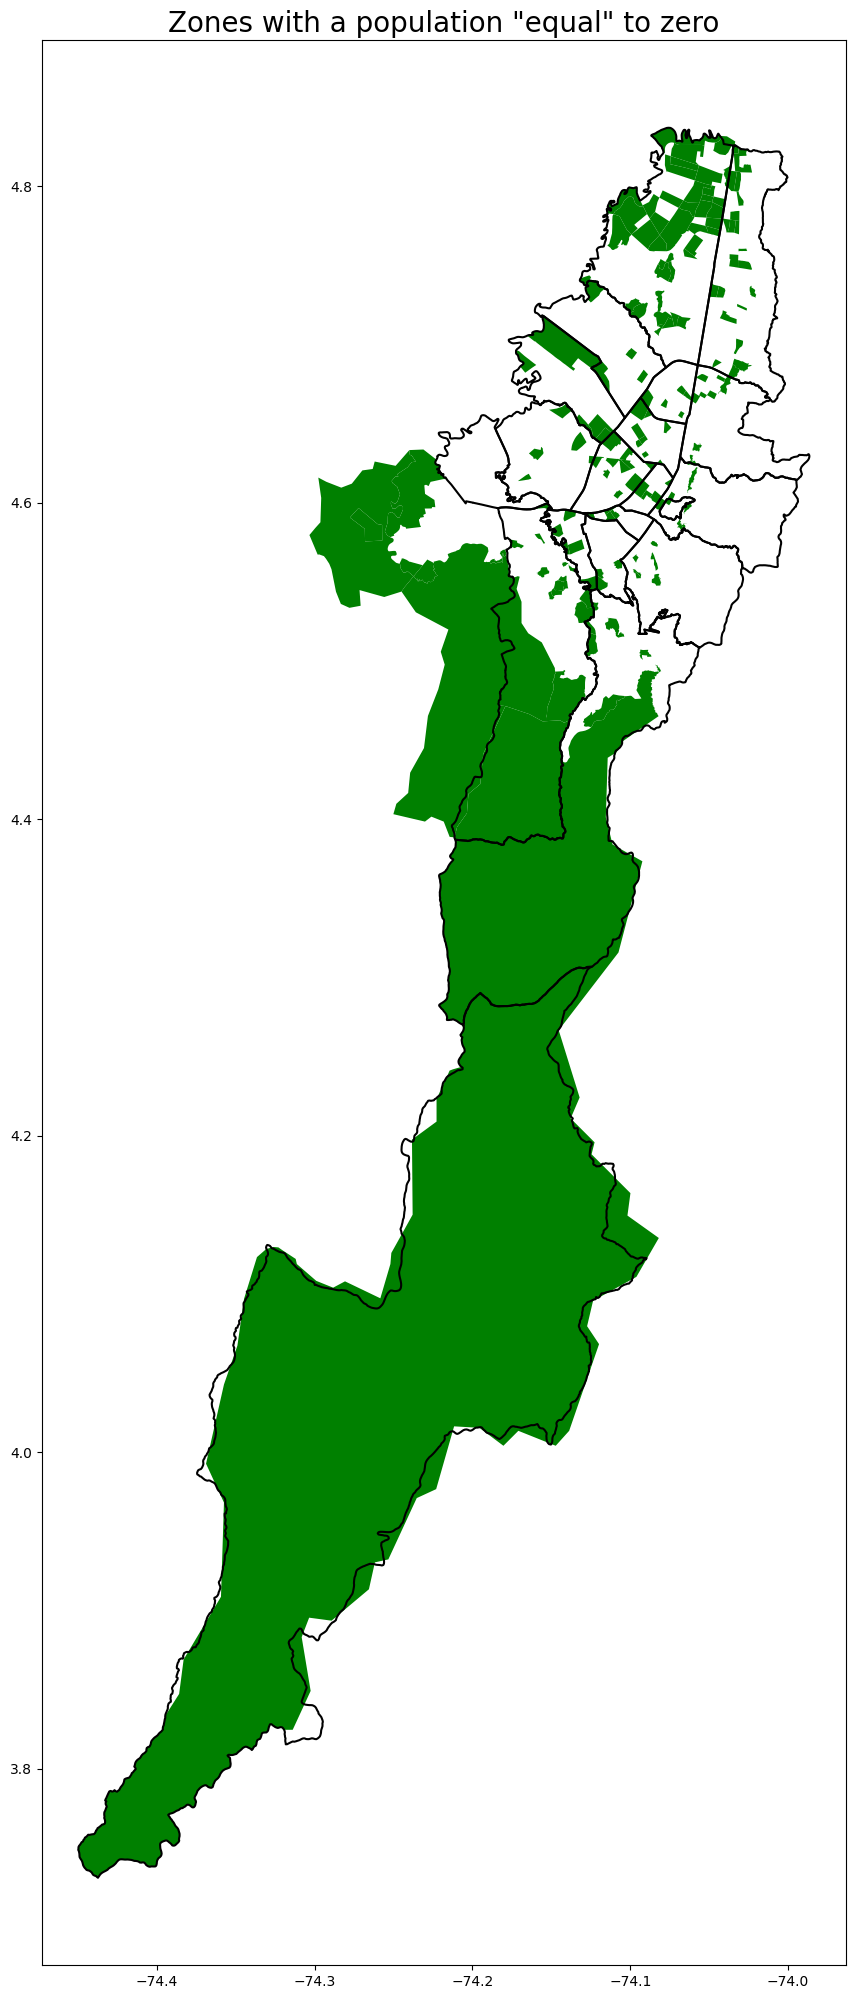

In [9]:
# Ploting the ZATs whit population equal to zero
mask = zats_map['ZAT'].isin(list(set(num_dis_sim['zat_origen'].unique())-set(population.index)))
pltn_zero = zats_map[mask]

fig, ax = plt.subplots(1, 1, figsize=(25, 25))
loc_map.boundary.plot(ax=ax, color='black')
pltn_zero.plot(color='g', ax=ax)
plt.title('Zones with a population "equal" to zero', fontsize = 20)
plt.plot()

In [10]:
num_trips_df[num_trips_df['zat_origen']==1]

zat_origen  zat_destino  trips
1         1.0         33.0   14.0
5         1.0        669.0    2.0
4         1.0         41.0    2.0
0         1.0          9.0    2.0
2         1.0         38.0    1.0
3         1.0         39.0    1.0
6         1.0       1028.0    1.0

En el mapa aparecen zonas bastante importantes en la ciudad, como el aeropuerto, el parque Simon Bolivar (el mas grande de la ciudad), y equipamentos como bibliotecas.

El modelo gravitcional no es capas de modelar los viajes que se realizan desde y hacia estas zonas.

In [11]:
# Adding the number of person in the survey per zat 
num_dis_sim = (num_dis_sim.merge(population, left_on='zat_origen', right_on='zat_hogar')
                          .rename(columns={'p7_total_personas': 'Origin Population'}))
num_dis_sim = (num_dis_sim.merge(population, left_on='zat_destino', right_on='zat_hogar')
                          .rename(columns={'p7_total_personas': 'Dest Population'})
                          .sort_values(by='trips', ascending=False)
                          .drop(columns=['Origin_center', 'Destination_center']))
num_dis_sim = num_dis_sim[['zat_origen', 'zat_destino', 'Origin Population', 'Dest Population', 'distance', 'trips']]
# Droping the repeated values
num_dis_sim = num_dis_sim.iloc[::2]
num_dis_sim.head(10)

zat_origen  zat_destino  Origin Population  Dest Population  \
0           551.0        530.0                145              518   
29891       775.0        776.0                184              311   
36580       714.0       1050.0                 64              229   
30182       782.0        783.0                187              230   
30084       776.0        777.0                311              274   
12843       743.0        744.0                471              115   
787         553.0       1006.0                244              178   
7653        784.0        782.0                265              187   
7654        778.0        782.0                106              187   
43676       159.0        161.0                109              213   

          distance  trips  
0       782.916312  139.0  
29891   666.616844  112.0  
36580  2542.549034  105.0  
30182   860.003059  100.0  
30084   899.246606   96.0  
12843   906.773827   83.0  
787     570.037103   79.0  
7653   1412.350471   77.0  
7654    809.763373   75.0  
43676   840.169254   74.0

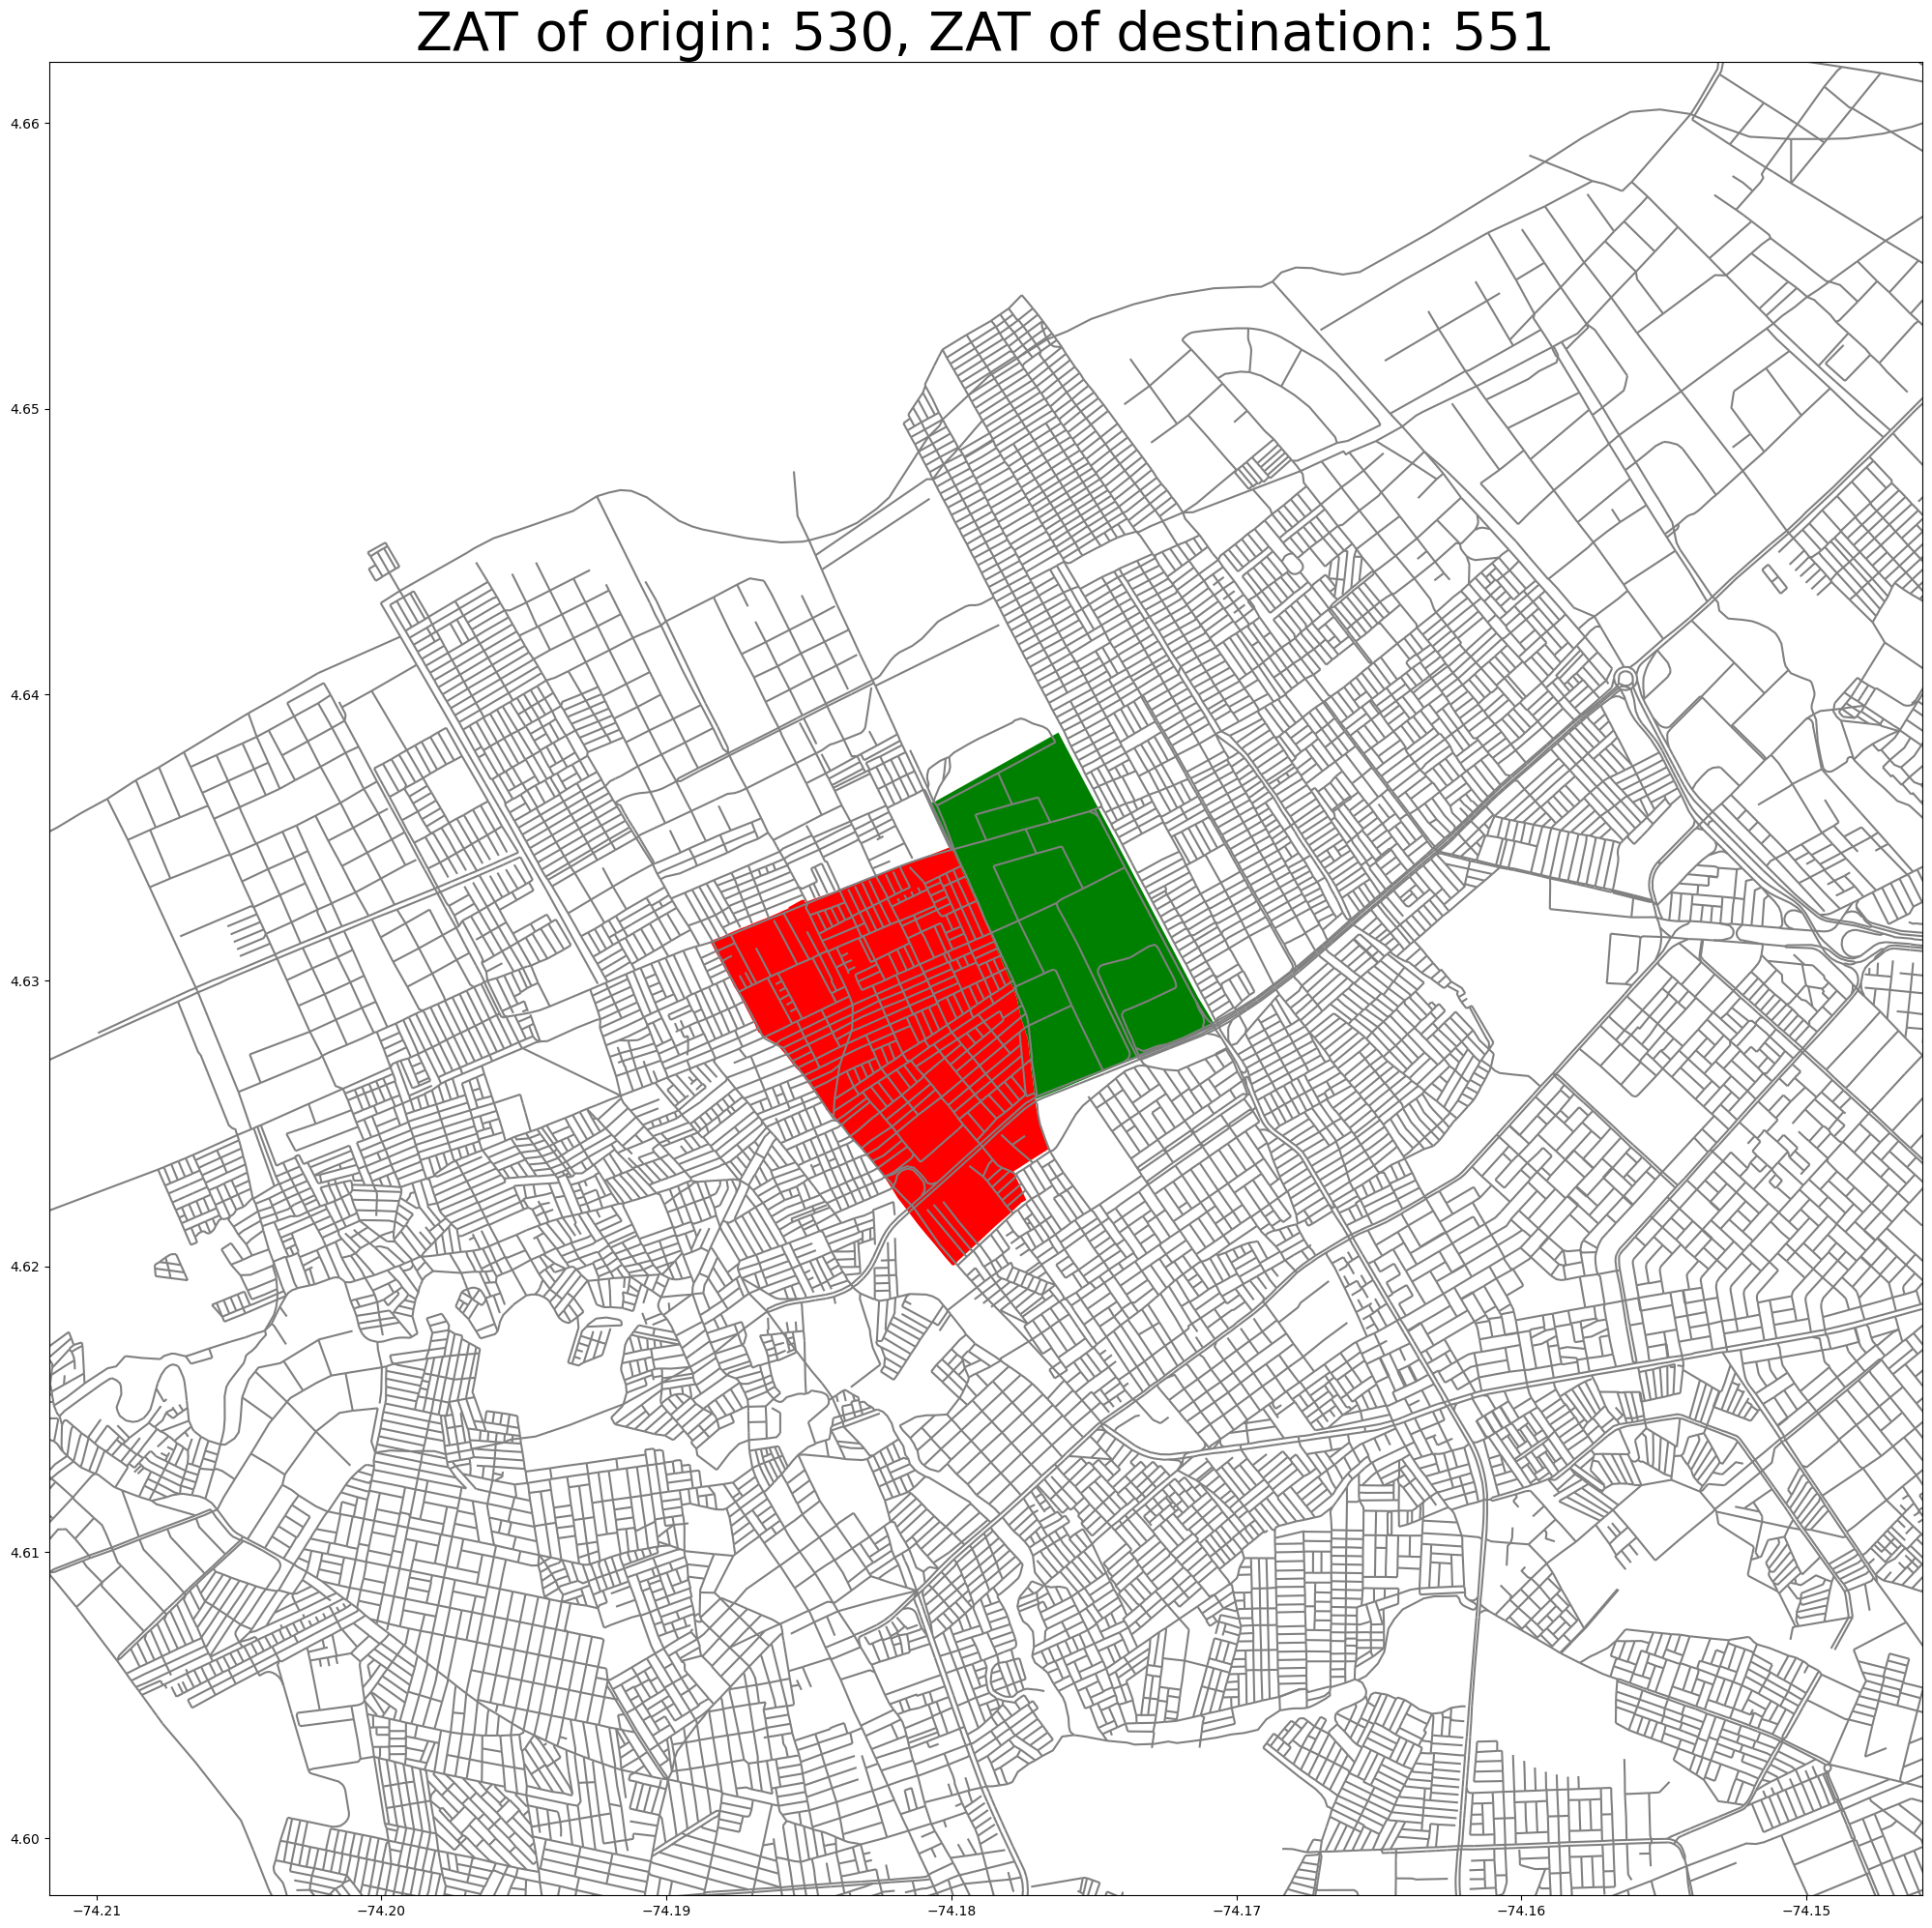

In [12]:
org_dest(530, 551)

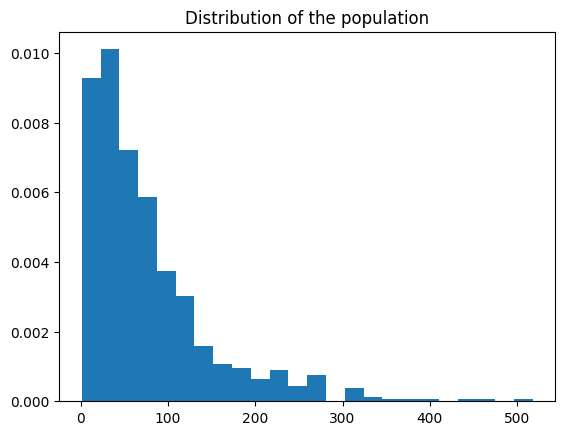

In [13]:
# Distribution of the population 
pltn_y, pltn_x = np.histogram(population['p7_total_personas'], bins=int(len(population)/30), density=True)
plt.stairs(pltn_y, pltn_x, fill=True)
plt.title('Distribution of the population')
plt.show()

[]

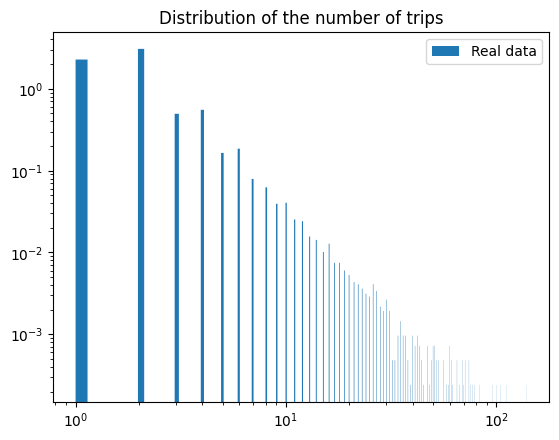

In [14]:
# Distribution of the number of trips between two zats
# In other words the distribution of weights of each trip
bins = int(len(num_dis_sim)/30)
data_trips_y, data_trips_x = np.histogram(num_dis_sim['trips'], bins=bins, density=True)
plt.stairs(data_trips_y, data_trips_x, fill=True, label='Real data')
plt.xscale('log')
plt.yscale('log')
plt.title('Distribution of the number of trips')
plt.legend()
plt.plot()

En la figura anterior podemos ver que el numero de personas que viajan entre dos zonas, la cual parece seguir una ley de potencias de la forma $ax^{-\alpha}$, por lo cual el modelo que de razón de la cantidad de viajes entre dos zonas debe seguir un mecanismo, el cual de como resultado una ley de potencias. 

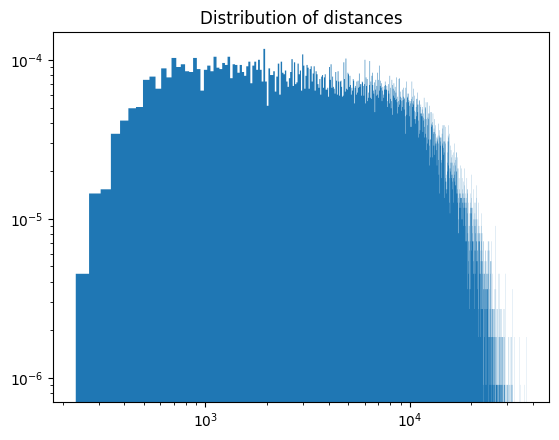

In [15]:
# Distribution of distances 
dist_y, dist_x = np.histogram(num_dis_sim['distance'], bins = bins, density=True)
plt.stairs(dist_y, dist_x, fill=True)
plt.xscale('log')
plt.yscale('log')
plt.title('Distribution of distances')
plt.show()


### Fitting

Con los datos organozados debidamente, se va a definir la función del modelo y se ajustarán los datos utilizando el metodo curve_fit de scipy para obtener un primer estimado de los parametros del modelo, posteriormente se usarán tecnicas mas rigurosas como el most likelyhood estimator y, usando los resultados del curve_fit aplicar inferencia bayesiana.

La función a ajustar es

$T_{ij} = K\frac{P_iP_j}{d_{ij}^{\alpha}}$

In [16]:
# Declaring the gravity function
def gravity(Data, K, a):
    P_1, P_2, d = Data
    T = K*(P_1*P_2)/(d**a)
    return T

# Spliting the data
ppltn_1 = np.array(num_dis_sim['Origin Population'])
ppltn_2 = np.array(num_dis_sim['Dest Population'])
dist = np.array(num_dis_sim['distance'])
# Tupple with the free parameters
data = (ppltn_1, ppltn_2, dist)
# Array with the number of trips between zats
trips = np.array(num_dis_sim['trips'])

# Fiting the data with the model
popt, pcov = curve_fit(gravity, data, trips)
print(popt)
print(np.sqrt(np.diag(pcov)))

# Computing the R^2 value
theo_trips = gravity(data, popt[0], popt[1])
r2_score(trips, theo_trips)

[1.21128826 1.10911796]
[0.0806066  0.00936993]


0.10965444912962641

El ajuste obtenido nos da unos parametros $K=0.80027608$ y $\alpha=1.05438672$, por lo cual el modelo sería $T_{ij} = 0.8\frac{P_iP_j}{d_{ij}^{1.05}}$, pero al calcular el $R^2$, obtenemos un valor de $0.1$, dandonos a entender que el ajuste a este modelo no es el mejor precisamente.

[]

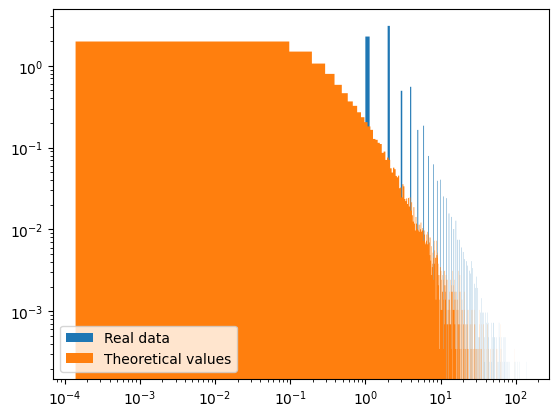

In [17]:
# Comparation between the distribution of trips given by the data and the model.
bins = int(len(num_dis_sim)/30)
data_trips_y, data_trips_x = np.histogram(num_dis_sim['trips'], bins=bins, density=True)
theo_trips_y, theo_trips_x = np.histogram(theo_trips, bins=bins, density=True)
plt.stairs(data_trips_y, data_trips_x, fill=True, label='Real data')
plt.stairs(theo_trips_y, theo_trips_x, fill=True, label='Theoretical values')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.plot()

Los datos serán ajustados a un modleo gravitacional modificado de la forma

$T_{ij} = K\frac{(P_iP_j)^{\beta}}{d_{ij}^{\alpha}}$

In [18]:
# Declaring the modified gravity function 
def mod_gravity(Data, K, a, b):
    P_1, P_2, d = Data
    T = K*(P_1*P_2)**b/(d**a)
    return T

# Fiting the data with the model
popt_mod, pcov_mod = curve_fit(mod_gravity, data, trips)
print(popt_mod)
print(np.sqrt(np.diag(pcov_mod)))

# Computing the R^2 value
mod_theo_trips = mod_gravity(data, popt_mod[0], popt_mod[1], popt_mod[2])
r2_score(trips, mod_theo_trips)

[41.74921399  0.75113488  0.39550388]
[2.4723901  0.00619399 0.00517886]


0.2669017514028573

El ajuste obtenido nos da unos parametros $K=38.26$, $\alpha=0.75$ y $\beta=0.4$, por lo cual el modelo sería $T_{ij} = 38.26\frac{(P_iP_j)^{0.4}}{d_{ij}^{0.75}}$, al calcular el $R^2$, obtenemos un valor de $0.26$, obteniendo una mejor con respect al modelo anterior, pero de todas formas el ajuste no es satisfactorio. 

[]

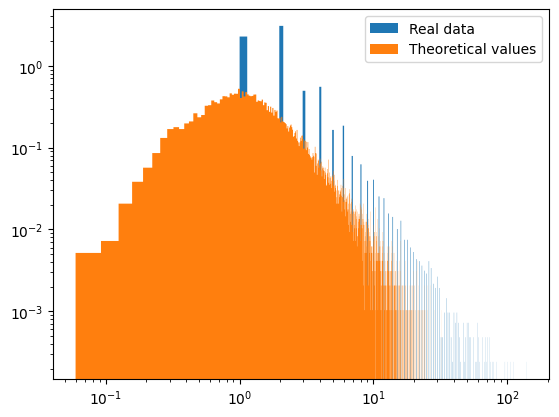

In [19]:
# Comparation between the distribution of trips given by the data and the modified model.
bins = int(len(num_dis_sim)/30)
data_trips_y, data_trips_x = np.histogram(num_dis_sim['trips'], bins=bins, density=True)
theo_trips_y, theo_trips_x = np.histogram(mod_theo_trips, bins=bins, density=True)
plt.stairs(data_trips_y, data_trips_x, fill=True, label='Real data')
plt.stairs(theo_trips_y, theo_trips_x, fill=True, label='Theoretical values')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.plot()

### Discución sobre el modelo gravitacional
Despues de mostrar los resultados obtnidos a mi director de TFM, Albert Diaz, llegamos a la conclusión de que este modelo no es valido para el tipo de datos que tenemos, porque basicamente estamos haciendo esto mal, esté tipo de modelo serviría para viajes entre zonas residenciales, pero no contempla los viajes entre una zona residencial y una zona de trabajo, razon por la cual ya no vamos a tomar la población de las zonas, si no que vamos a ajustar el modelo para que tome el numero de viajes de origen, y numero de viajes de destino de una determinada zona, por lo cual, nuestro gravitacional modificado sería.

$T_{ij}=\frac{O_iD_j}{R^{\alpha}}$ 

Como podemos observar, en ninguno de los dos casos de modelo gravitacional se ajustan a los datos de una manera satisfactoria, razón por la cual se debe seguir investigando y buscando que tipo de modelo que ajusta de una mejor manera.

Proximas tareas:
Ajustar la distribución de numero de viajes a una ley de potencias y encontrar dichos parametros. 
La idea sería, a partir de esta distribución encontrar que modelos o mecanismos dan como resultado un tipo de distribucíon de ley de potencias.

Hacer algo tipo $T_{ij}=\frac{O_iD_j}{R^{\alpha}}$ 

Probar modelo radiacional
Revisar el tipo de datos que tengo

In [20]:
num_trips_df

zat_origen  zat_destino  trips
39697       530.0        551.0   73.0
41272       551.0        530.0   66.0
52314       776.0        775.0   56.0
52206       775.0        776.0   56.0
49520       714.0       1050.0   53.0
...           ...          ...    ...
23005       317.0         61.0    1.0
23006       317.0         69.0    1.0
23007       317.0         72.0    1.0
23008       317.0         75.0    1.0
59570      1908.0        933.0    1.0

[58931 rows x 3 columns]

### Analisis de redes complejas

Se calcularan las estadisticas de la red de movilidad, tales como la distribución del grado, de fuerza nodal total, de salida y entrada, distribución de los pesos de los links, tanto dirigidos como no dirigidos.

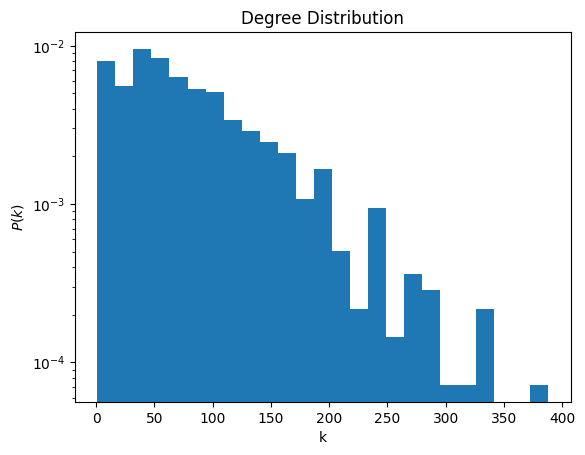

In [21]:
# Non directed Degree distribution
sim_num_trips.loc[:, ['counts']]=1
degree_dist = (sim_num_trips.groupby('zat_origen', as_index=False)['counts']
                            .agg('sum')
                            .sort_values(by='counts', ascending=False))
bins = int(len(degree_dist)/30)
y_degree, x_degree =np.histogram(degree_dist['counts'],bins=25 ,density=True)

# Ploting the degree distribution
plt.stairs(y_degree, x_degree, fill=True)
plt.xlabel('k')
plt.ylabel(r'$P(k)$')
# plt.xscale('log')
plt.yscale('log')
plt.title('Degree Distribution')
plt.show()

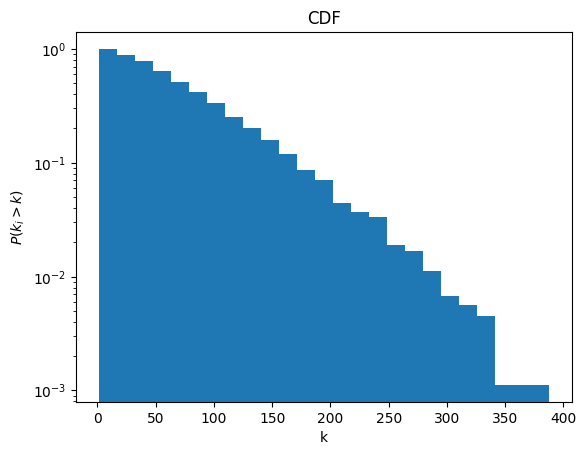

In [22]:
# Computing the complmentary cumulative degree distribution
cdf = []
bin_weight = x_degree[1]-x_degree[0]
my_degree = list(y_degree*bin_weight)
for i in range(len(y_degree)):
    p = sum(my_degree[i:])
    cdf.append(p)

# Ploting the CDF 
plt.stairs(cdf, x_degree, fill=True)
plt.xlabel('k')
plt.ylabel(r'$P(k_i>k)$')
#plt.xscale('log')
plt.yscale('log')
plt.title('CDF')
plt.show()

[]

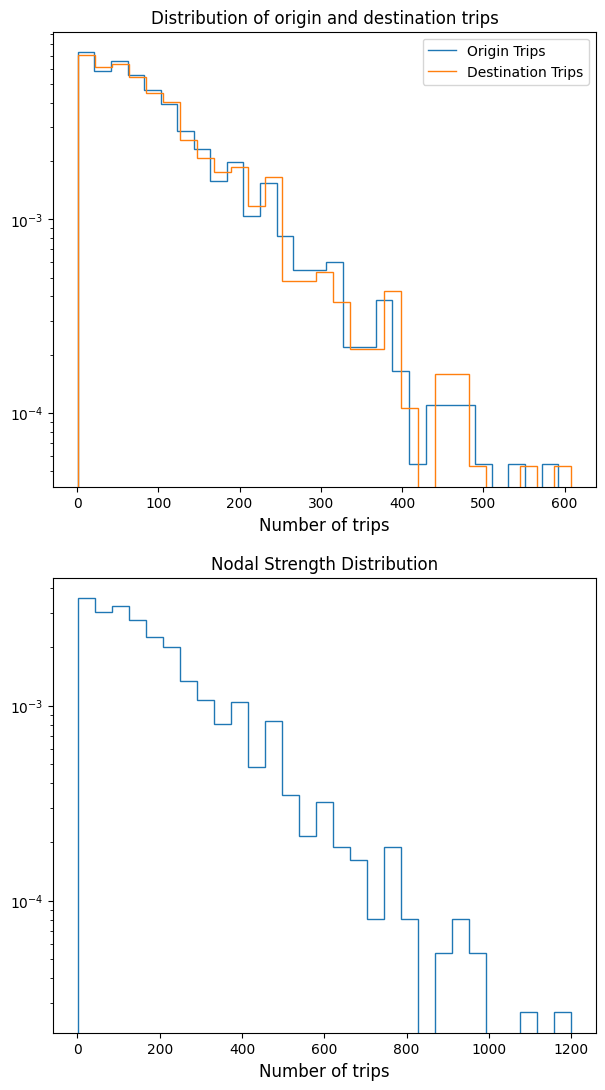

In [23]:
# Counting the number of origin trips of each ZAT

origin_trips = (num_trips_df.groupby('zat_origen', as_index=False)['trips']
                .agg('sum')
                .sort_values(by='trips', ascending=False))
dest_trips = (num_trips_df.groupby('zat_destino', as_index=False)['trips']
                .agg('sum')
                .sort_values(by='trips', ascending=False))
total_trips = origin_trips.merge(dest_trips, left_on='zat_origen', right_on='zat_destino')
total_trips['trips']=total_trips[['trips_x', 'trips_y']].sum(axis=1)
total_trips = (total_trips.drop(columns=['trips_x', 'trips_y', 'zat_destino'])
                          .rename(columns={'zat_origen': 'ZAT'}))
# Adding the mising zats that only have one trip
miss_zats = list(set(origin_trips['zat_origen'])^set(dest_trips['zat_destino']))
new_data= pd.DataFrame({'ZAT': miss_zats,
           'trips':np.ones(len(miss_zats))})
total_trips = pd.concat([total_trips, new_data], ignore_index=True)

# Distribution of number of trips per origin and destination
# In other words the nodal strenght
bins = int(len(origin_trips)/30)
org_y, org_x = np.histogram(origin_trips['trips'], bins=bins, density=True)
dest_y, dest_x = np.histogram(dest_trips['trips'], bins=bins, density=True)
# Distribution of number of trips per each ZAT
tot_y, tot_x = np.histogram(total_trips['trips'], bins=bins, density=True)

# Ploting the distributions 
fig, ax = plt.subplots(2, figsize = (7,13))
# Distributon of origin and destination trips
ax[0].stairs(org_y, org_x, label='Origin Trips')
ax[0].stairs(dest_y, dest_x, label='Destination Trips')
ax[0].set_xlabel('Number of trips', fontsize = 12)
ax[0].legend()
#ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('Distribution of origin and destination trips')
# Distributions of trips per ZAT
ax[1].stairs(tot_y, tot_x)
ax[1].set_xlabel('Number of trips', fontsize = 12)
#ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_title('Nodal Strength Distribution')

plt.plot()

In [24]:
num_dis_trips = (num_dis_trips.merge(origin_trips, left_on='zat_origen', right_on='zat_origen')
                              .rename(columns={'trips_x': 'Trips', 'trips_y': 'Origin Trips'}))
num_dis_trips = (num_dis_trips.merge(dest_trips, left_on='zat_destino', right_on='zat_destino')
                              .rename(columns={'trips': 'Destination Trips'})
                              .sort_values(by='Trips', ascending=False))
num_dis_trips = num_dis_trips[['zat_origen', 'zat_destino', 'Origin Trips', 'Destination Trips', 'Origin_center', 'Destination_center', 'Trips']]
num_dis_trips

zat_origen  zat_destino  Origin Trips  Destination Trips  \
0           530.0        551.0         496.0              305.0   
27644       551.0        530.0         308.0              482.0   
22817       776.0        775.0         332.0              192.0   
9609        775.0        776.0         187.0              343.0   
34151       714.0       1050.0         108.0              201.0   
...           ...          ...           ...                ...   
28759       146.0        985.0         145.0              224.0   
28760       553.0        992.0         313.0              143.0   
8434        271.0        317.0         282.0              397.0   
28762       501.0        992.0         364.0              143.0   
29465       744.0        294.0         159.0              212.0   

                   Origin_center         Destination_center  Trips  
0      POINT (-74.17593 4.63213)  POINT (-74.18166 4.62800)   73.0  
27644  POINT (-74.18166 4.62800)  POINT (-74.17593 4.63213)   66.0  
22817  POINT (-74.19802 4.57757)  POINT (-74.19736 4.58356)   56.0  
9609   POINT (-74.19736 4.58356)  POINT (-74.19802 4.57757)   56.0  
34151  POINT (-74.16040 4.55118)  POINT (-74.15788 4.52832)   53.0  
...                          ...                        ...    ...  
28759  POINT (-74.05197 4.70272)  POINT (-74.12396 4.59152)    1.0  
28760  POINT (-74.18640 4.64169)  POINT (-74.07096 4.61493)    1.0  
8434   POINT (-74.06362 4.62801)  POINT (-74.13542 4.66422)    1.0  
28762  POINT (-74.10056 4.58520)  POINT (-74.07096 4.61493)    1.0  
29465  POINT (-74.10989 4.50800)  POINT (-74.09502 4.64497)    1.0  

[58931 rows x 7 columns]

In [25]:
# Calculating the distances in meters
distance = []
geod = Geod(ellps = 'WGS84')
for i in range(len(num_dis_trips)):
    line = LineString([num_dis_trips['Origin_center'].iloc[i], num_dis_trips['Destination_center'].iloc[i]])
    dist = geod.geometry_length(line)
    distance.append(dist)

num_dis_trips['distance'] = distance
num_dis_trips = num_dis_trips[['zat_origen', 'zat_destino', 'Origin Trips', 'Destination Trips', 'distance','Trips']]
num_dis_trips

zat_origen  zat_destino  Origin Trips  Destination Trips      distance  \
0           530.0        551.0         496.0              305.0    782.916312   
27644       551.0        530.0         308.0              482.0    782.916312   
22817       776.0        775.0         332.0              192.0    666.616844   
9609        775.0        776.0         187.0              343.0    666.616844   
34151       714.0       1050.0         108.0              201.0   2542.549034   
...           ...          ...           ...                ...           ...   
28759       146.0        985.0         145.0              224.0  14662.883396   
28760       553.0        992.0         313.0              143.0  13146.409920   
8434        271.0        317.0         282.0              397.0   8915.937944   
28762       501.0        992.0         364.0              143.0   4647.479686   
29465       744.0        294.0         159.0              212.0  15236.731982   

       Trips  
0       73.0  
27644   66.0  
22817   56.0  
9609    56.0  
34151   53.0  
...      ...  
28759    1.0  
28760    1.0  
8434     1.0  
28762    1.0  
29465    1.0  

[58931 rows x 6 columns]

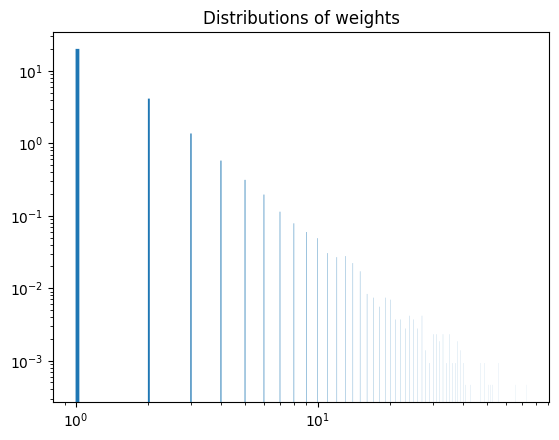

In [26]:
# Distribution of the weighted links in the non-directed network
bins = int(len(num_dis_trips)/30)
trips_y, trips_x = np.histogram(num_dis_trips['Trips'],bins = bins ,density=True )

plt.stairs(trips_y, trips_x, fill=True)
plt.title('Distributions of weights')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [27]:
num_dis_trips

zat_origen  zat_destino  Origin Trips  Destination Trips      distance  \
0           530.0        551.0         496.0              305.0    782.916312   
27644       551.0        530.0         308.0              482.0    782.916312   
22817       776.0        775.0         332.0              192.0    666.616844   
9609        775.0        776.0         187.0              343.0    666.616844   
34151       714.0       1050.0         108.0              201.0   2542.549034   
...           ...          ...           ...                ...           ...   
28759       146.0        985.0         145.0              224.0  14662.883396   
28760       553.0        992.0         313.0              143.0  13146.409920   
8434        271.0        317.0         282.0              397.0   8915.937944   
28762       501.0        992.0         364.0              143.0   4647.479686   
29465       744.0        294.0         159.0              212.0  15236.731982   

       Trips  
0       73.0  
27644   66.0  
22817   56.0  
9609    56.0  
34151   53.0  
...      ...  
28759    1.0  
28760    1.0  
8434     1.0  
28762    1.0  
29465    1.0  

[58931 rows x 6 columns]

Hay que hacer una distinción muy importante entre las distribuciones que tengo, el primer conjunto de estas, las que ajuste con el modelo gravitacional son distribuciones del peso de los links de la red no direccionada, mientras que el segundo conjunto de distribuciones son los de la fuerza nodal, de entrada, de salida y la suma total, el anterior grafico muestra la distribución de los pesos de los links de la red direccionada.

### Modelo gravitacional modificado

En esta sección trabajaremos en ajustar nuestros datos al modelo gravitacional modificado propuesto por Albert, el cual tiene la forma

$T_{ij}=\frac{O_iD_j}{R^{\alpha}}$ 

In [28]:
# Fiting the data with the new model
def origin_dest(Data, a):
    O_1, D_2, d = Data
    T = (O_1*D_2)/(d**a)
    return T

# Spliting the dara 
origin = np.array(num_dis_trips['Origin Trips'])
dest = np.array(num_dis_trips['Destination Trips'])
distance = np.array(num_dis_trips['distance'])
# Tupple with the free parameters
data = (origin, dest, distance)
# Array with the number of non-simetrical trips between zats
trips = np.array(num_dis_trips['Trips'])

# Fiting the data with the new model
popt, pcov = curve_fit(origin_dest, data, trips)
print(popt)
print(np.sqrt(np.diag(pcov)))

# Computing the R^2 value
theo_trips_1 = origin_dest(data, popt[0])
r2_score(trips, theo_trips_1)

[1.33990997]
[0.00083819]


-0.10200698419931564

In [29]:
# Fiting the data with the modified new model
def origin_dest(Data, K, a):
    O_1, D_2, d = Data
    T = K*(O_1*D_2)/(d**a)
    return T

# Fiting the data with the new model
popt, pcov = curve_fit(origin_dest, data, trips)
print(popt)
print(np.sqrt(np.diag(pcov)))

# Computing the R^2 value
theo_trips_2 = origin_dest(data, popt[0], popt[1])
r2_score(trips, theo_trips_2)

[0.01438882 0.72379251]
[0.00054185 0.00499753]


0.047502644006242156

En el siguiente caso vamos a ajustar los datos a una versión que sigue una ley de potencias del modelo gravitacional modificado, el cual está dado por.

$T_{ij} = K\frac{(O_iD_j)^{\beta}}{d_{ij}^{\alpha}}$

In [30]:
# Declaring the power modified gravity function 
def pow_mod(Data, K, a, b):
    O_1, D_2, d = Data
    T = K*(O_1*D_2)**b/(d**a)
    return T

# Fiting the data with the model
popt_mod, pcov_mod = curve_fit(pow_mod, data, trips)
print(popt_mod)
print(np.sqrt(np.diag(pcov_mod)))

# Computing the R^2 value
mod_theo_trips = pow_mod(data, popt_mod[0], popt_mod[1], popt_mod[2])
r2_score(trips, mod_theo_trips)

[6.557052   0.6113596  0.36599361]
[0.31219078 0.0039599  0.00416604]


0.23131923858040715

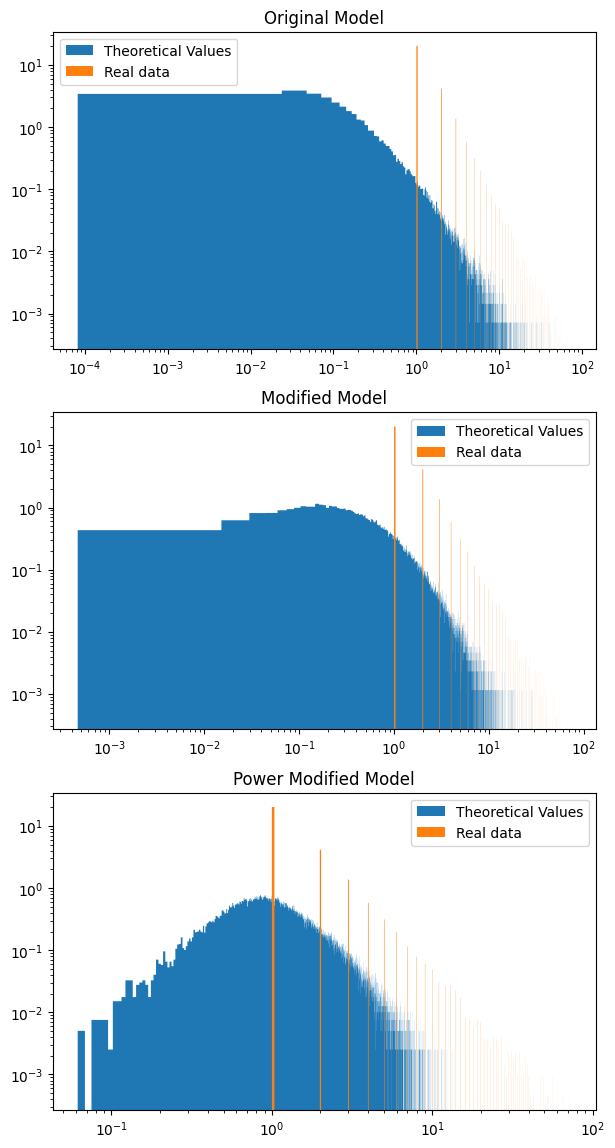

In [31]:
# Ploting the distribution given by the models compared with the real data
theo_1_y, theo_1_x = np.histogram(theo_trips_1, bins=bins,density=True)
theo_2_y, theo_2_x = np.histogram(theo_trips_2, bins=bins,density=True)
theo_3_y, theo_3_x = np.histogram(mod_theo_trips, bins=bins,density=True)

fig, ax = plt.subplots(3, figsize= (7, 14))
ax[0].stairs(theo_1_y, theo_1_x, fill=True, label='Theoretical Values')
ax[0].stairs(trips_y, trips_x, fill=True, label='Real data')
ax[0].legend()
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('Original Model')

ax[1].stairs(theo_2_y, theo_2_x, fill=True, label='Theoretical Values')
ax[1].stairs(trips_y, trips_x, fill=True, label='Real data')
ax[1].legend()
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_title('Modified Model')

ax[2].stairs(theo_3_y, theo_3_x, fill=True, label='Theoretical Values')
ax[2].stairs(trips_y, trips_x, fill=True, label='Real data')
ax[2].legend()
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_title('Power Modified Model')

plt.show()

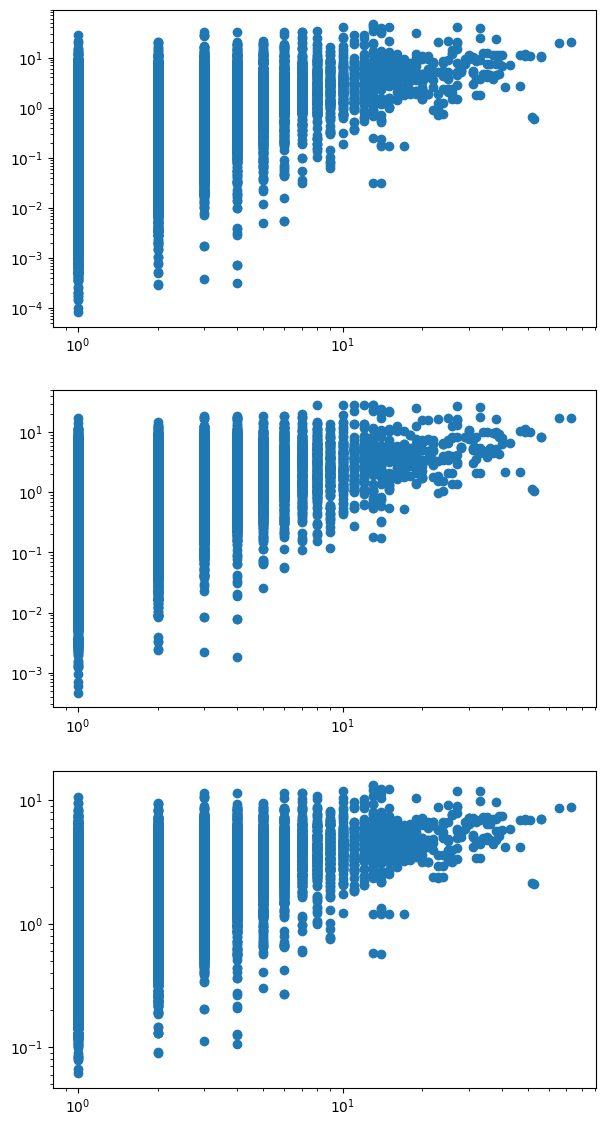

In [32]:
# Ploting the theoretical values vs the real data

fig, ax = plt.subplots(3, figsize=(7, 14))

ax[0].scatter(trips, theo_trips_1)
ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[1].scatter(trips, theo_trips_2)
ax[1].set_xscale('log')
ax[1].set_yscale('log')

ax[2].scatter(trips, mod_theo_trips)
ax[2].set_xscale('log')
ax[2].set_yscale('log')

Como podemos observar, el modelo modificado propuesto tampoco tubo resultados satisfactorios, podemos ver que la distribución de los datos obtenidos demanera teoríca no reproduce la ley de potencias que siguen los datos teorícos.

In [33]:
# Normalizing the data and fiting with the power modified model as a test
norm_org = origin/sum(origin)
norm_dest = dest/sum(dest)
norm_data = (norm_org, norm_dest, distance)
norm_trips = trips/sum(trips)

# Fiting the normalized data with the power modified model
popt_mod, pcov_mod = curve_fit(pow_mod, norm_data, norm_trips)
print(popt_mod)
print(np.sqrt(np.diag(pcov_mod)))

# Computing the R^2 value
norm_theo_trips = pow_mod(norm_data, popt_mod[0], popt_mod[1], popt_mod[2])
r2_score(norm_trips, norm_theo_trips)

C:\Users\User\AppData\Local\Temp\ipykernel_25252\1831867677.py:4: RuntimeWarning: overflow encountered in power
  T = K*(O_1*D_2)**b/(d**a)


[9.42065989 0.61137083 0.36600412]
[0.95899339 0.00396001 0.00416614]


0.2313192384184094

In [34]:
norm_theo_trips

array([9.25529128e-05, 9.19167798e-05, 7.44236321e-05, ...,
       1.87350245e-05, 2.10817949e-05, 8.70107155e-06])

#### Discusión
Como se ha visto, los dos primeros modelos no han arrojado resultados satisfactorios, para el caso del modelo gravitacional, concluimos que el conjunto de datos que tenemos no srve para ajustar con este modelo. Ahora con respecto al modelo modificado, todavía tenemos el comportamiento de que los viajes decrecen a medida que la distancia aumenta, ¿pero en verdad pasa esto?, tengo la hipotesis de que los viajes poco numerosos no presentan un comportamiento regular con respecto a la distancia, es decir, puedo encontrar distancias muy pequeñas entre dos zonas donde solo se hizo un solo viaje. 

### Analisis de numero pequeño de viajes
Se analizaran los patrones presentes en los viajes poco numeroso, se haran distribuciones de la distancia de los viajes y de la fuerza nodal. 

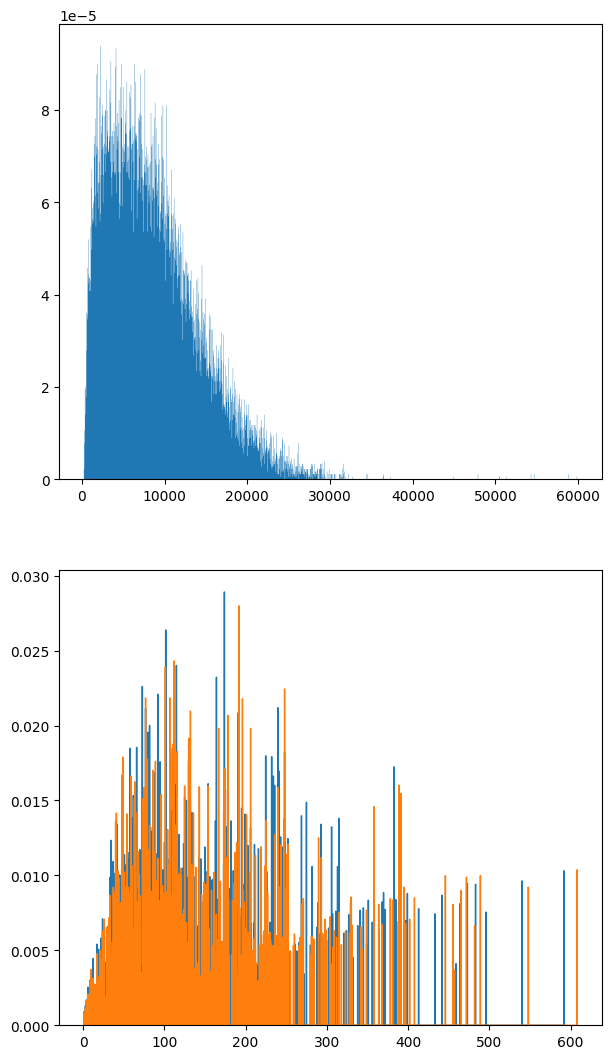

In [35]:
# Filtering the data to the low number of trips
low_num_trips = num_dis_trips[num_dis_trips['Trips']==1]
bins = int(len(low_num_trips)/30)
low_dis_y, low_dis_x = np.histogram(low_num_trips['distance'],bins=bins ,density=True)
low_or_y, low_or_x = np.histogram(low_num_trips['Origin Trips'],bins=bins ,density=True)
low_dest_y, low_dest_x = np.histogram(low_num_trips['Destination Trips'],bins=bins ,density=True)

# Ploting the distributions
fig, ax = plt.subplots(2, figsize=(7, 13))
# Distribution of distances
ax[0].stairs(low_dis_y, low_dis_x, fill=True)

ax[1].stairs(low_or_y, low_or_x)
ax[1].stairs(low_dest_y, low_dest_x)

plt.show()

Como podemos observar, para los viajes de una sola persona, se tienen distancias y fuerza nodal de todos los colores y sabores, no se sigue una tendencia tan clara de grandes distancias y baja fuerza nodal.
Lo que sucede a la hora de ajustar con los modelos propuestos es que, son tantos los viajes de una sola persona que el modelo va a tratar de ajustar miles de datos con parametros bastante diversos a un solo viaje entre dos ZATs, y es por eso que los dos modelos están fallando. 

### Modelo de radiaciones

La siguiente tarea es verificar si los datos se ajustan a un modelo de radiaciones, el cual está dado por.

$T_{ij} = T_i\frac{m_im_j}{(m_i+s_{ij})(m_i+m_j+s_{ij})}$

En donde $T_{ij}$ es el flujo de personas entre las zonas $i$ y $j$, $T_i$ el flujo de personas que la zona $i$ emite, $m_i$ y $m_j$ son las poblaciones de las zonas $i$ y $j$, y finalmente $s_{ij}$ se define como el numero de oportunidades entre las zonas $i$ y $j$, y segun la fuente que se use tiene diferentes definiciones, en Barthelemy (2016) $s_{ij}$ es el numero de nodos $w$ tal que $d(i,w)<d(i,j)$, mientras que en Simini et,al (2012), $s_{ij}$ denota la población en un radio dado por la distaincia $r_{ij}$, es decir, $s_{ij}=\sum_{w\neq i,j} m_w$ tal que $d(i,w)<d(i,j)$.
Cabe destacar que este modelo no es simetrico, es decir, $T_{ij}\neq T_{ji}$, a diferencia del modelo gravitacional.

Bueno ya descrito el modelo es hora de pasar a la discusión, como sabemos, nuestros datos no dan razon de la población en ciertas zonas a las que si viaja gente dado que estas zonas son poligonos industriales o tienen otros equipamentos, por lo cual se puede pensar en versiones modificadas del modelo de radiaciones que se adapte a nuestros datos, la primera es, en vez de usar la población $m_i$, se puede usar la fuerza nodal de cada ZAT, se podría usar la fuerza nodal total, la de salida y la de entrada. Como una primera propuesta, teniendo en cuenta que el modelo es antisimetrico por definición, utilizaré $m_i$ como la fuerza nodal total y $s_{ij}$ será la suma de todas las fuerzas nodales entre cada zona. 

In [36]:
# Adding the nodal strength to our dataframe
num_dis_trips = (num_dis_trips.merge(total_trips, left_on='zat_origen', right_on='ZAT')
                              .rename(columns={'trips': 'Org Nodal Strength'}))
num_dis_trips = (num_dis_trips.merge(total_trips, left_on='zat_destino', right_on='ZAT')
                              .rename(columns={'trips': 'Dest Nodal Strength'}))
num_dis_trips = num_dis_trips[['zat_origen', 'zat_destino', 'Origin Trips', 'Destination Trips', 'Org Nodal Strength', 'Dest Nodal Strength', 'distance','Trips']]
num_dis_trips

zat_origen  zat_destino  Origin Trips  Destination Trips  \
0           530.0        551.0         496.0              305.0   
1           782.0        551.0         459.0              305.0   
2           743.0        551.0         397.0              305.0   
3           553.0        551.0         313.0              305.0   
4          1006.0        551.0         184.0              305.0   
...           ...          ...           ...                ...   
58926        61.0       1054.0         154.0                1.0   
58927       129.0        478.0          77.0                1.0   
58928        70.0         31.0          61.0                1.0   
58929       367.0       1040.0          70.0                1.0   
58930       498.0        268.0          18.0                1.0   

       Org Nodal Strength  Dest Nodal Strength      distance  Trips  
0                   978.0                613.0    782.916312   73.0  
1                   916.0                613.0   6431.021532    1.0  
2                   799.0                613.0  15521.650471    2.0  
3                   621.0                613.0   1602.353335   13.0  
4                   363.0                613.0   1644.041830    6.0  
...                   ...                  ...           ...    ...  
58926               309.0                  2.0   8854.206577    1.0  
58927               152.0                  1.0  12150.720646    1.0  
58928               122.0                  2.0   4631.768596    1.0  
58929               138.0                  2.0  23086.553077    1.0  
58930                38.0                  2.0   6256.761963    1.0  

[58931 rows x 8 columns]

In [37]:
# Computing the quantity s_ij

# Measure the distance between two zats
def zats_distance(or_zat, dest_zat):
    geod = Geod(ellps = 'WGS84')
    org_point = zats_map[zats_map['ZAT']==or_zat]['center'].iloc[0]
    dest_point = zats_map[zats_map['ZAT']==dest_zat]['center'].iloc[0]
    line = LineString([org_point, dest_point])
    dist = geod.geometry_length(line)
    return dist
zats_distance(530, 551)

# Measuring the distance between each ZAT 
zats_array = np.array(zats_map['ZAT'])
distances_array = []
zat_i = []
zat_j =[]
def dist_zats():
    for i in range(1, len(zats_array)):
        #print(i)
        for j in range(i+1, len(zats_array)):
            zat_i.append(zats_array[i])
            zat_j.append(zats_array[j])
            d = zats_distance(zats_array[i], zats_array[j])
            distances_array.append(d)
    return distances_array
distances_array = dist_zats()


In [38]:
# Making a dataframe with all the distances between zats
dict = {'zat i': zat_i, 'zat j': zat_j, 'Distances': distances_array}
dist_df = pd.DataFrame(dict).sort_values(by='Distances')

# Computing s_ij for each trip registered 
s_ij = []
for i in range(len(num_dis_trips)):
    orgn = num_dis_trips.iloc[i]['zat_origen']
    dest = num_dis_trips.iloc[i]['zat_destino']
    #print(orgn, dest)
    my_dist = zats_distance(orgn, dest)
    my_array = dist_df[(dist_df['zat i']==orgn)|(dist_df['zat j']==orgn)]
    my_array = my_array[my_array['Distances']<my_dist]
    my_zones = list(my_array[my_array['zat i']==orgn]['zat j'])+list(my_array[my_array['zat j']==orgn]['zat i'])
    s = 0
    for j in my_zones:
        try:
            s = total_trips[total_trips['ZAT']==j]['trips'].iloc[0]+s
        except:
            continue
    s_ij.append(s)
    
# Adding the s_ij quantity to the dataframe 
num_dis_trips.loc[:, 's_ij'] = s_ij
num_dis_trips

In [ ]:
# Computing the theoretical values given by the radiation model
T_i = np.array(num_dis_trips['Origin Trips'])
m_i = np.array(num_dis_trips['Org Nodal Strength'])
m_j = np.array(num_dis_trips['Dest Nodal Strength'])
s_ij = np.array(s_ij)
T_ij = T_i*(m_i*m_j)/((m_i+s_ij)*(m_i+m_j+s_ij))

num_dis_trips.loc[:, 'Theo Trips'] = T_ij
num_dis_trips = num_dis_trips[['zat_origen', 'zat_destino', 'Origin Trips', 'Destination Trips', 'Org Nodal Strength', 'Dest Nodal Strength', 'distance', 's_ij', 'Trips', 'Theo Trips']]
num_dis_trips

zat_origen  zat_destino  Origin Trips  Destination Trips  \
0           530.0        551.0         496.0              305.0   
1           782.0        551.0         459.0              305.0   
2           743.0        551.0         397.0              305.0   
3           553.0        551.0         313.0              305.0   
4          1006.0        551.0         184.0              305.0   
...           ...          ...           ...                ...   
58926        61.0       1054.0         154.0                1.0   
58927       129.0        478.0          77.0                1.0   
58928        70.0         31.0          61.0                1.0   
58929       367.0       1040.0          70.0                1.0   
58930       498.0        268.0          18.0                1.0   

       Org Nodal Strength  Dest Nodal Strength      distance      s_ij  Trips  \
0                   978.0                613.0    782.916312     493.0   73.0   
1                   916.0                613.0   6431.021532   16860.0    1.0   
2                   799.0                613.0  15521.650471  105415.0    2.0   
3                   621.0                613.0   1602.353335    2695.0   13.0   
4                   363.0                613.0   1644.041830    2031.0    6.0   
...                   ...                  ...           ...       ...    ...   
58926               309.0                  2.0   8854.206577   47580.0    1.0   
58927               152.0                  1.0  12150.720646  122166.0    1.0   
58928               122.0                  2.0   4631.768596   23709.0    1.0   
58929               138.0                  2.0  23086.553077  189489.0    1.0   
58930                38.0                  2.0   6256.761963   52910.0    1.0   

         Theo Trips  
0      9.699975e+01  
1      7.884542e-01  
2      1.713701e-02  
3      9.145340e+00  
4      5.687578e+00  
...             ...  
58926  4.149727e-05  
58927  7.822580e-07  
58928  2.620588e-05  
58929  5.372819e-07  
58930  4.879447e-07  

[58931 rows x 10 columns]

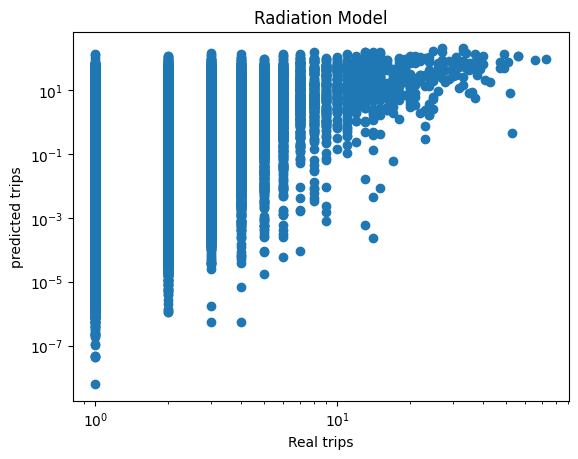

In [ ]:
# Ploting the accuracy of the model

plt.scatter(num_dis_trips['Trips'], num_dis_trips['Theo Trips'])
plt.xlabel('Real trips')
plt.ylabel('predicted trips')
plt.xscale('log')
plt.yscale('log')
plt.title('Radiation Model')
plt.show()

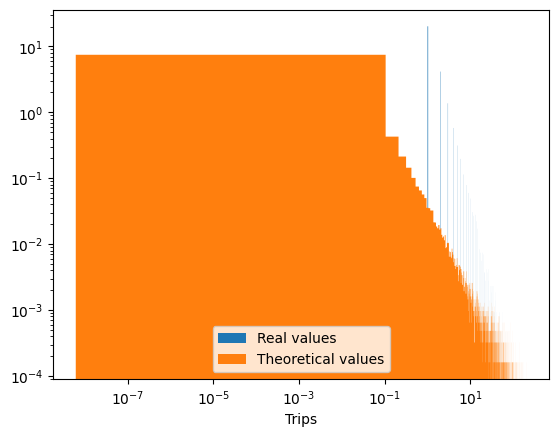

In [ ]:
# Real distribution vs predicted distribution
bins = int(len(num_dis_trips)/30)
y_real, x_real = np.histogram(num_dis_trips['Trips'],bins=bins ,density=True)
y_pred, x_pred = np.histogram(num_dis_trips['Theo Trips'],bins=bins ,density=True)

plt.stairs(y_real, x_real, fill=True, label='Real values')
plt.stairs(y_pred, x_pred, fill=True, label='Theoretical values')
plt.legend()
plt.xlabel('Trips')
# plt.ylabel('P(T)')
plt.xscale('log')
plt.yscale('log')
plt.show()

#### Proximas tareas

Calcular el parametro $s_{ij}$ para cada uno de los viajes y ajustar los datos al modelo de radiaciones. 

Entre los datos se encuentran numerosos viajes cuya zat de origen o destino es 0.0, pero esta es una zat que al precer no existe ya que no aparece en el shapefile de zats, y son numerosas las UTAMs que la contienen, por lo cual no se debe fiar de estos registros, con lo cual tenemos dos opciones, rellenar estos datos de alguna manera o borrarlos.

Porque es bonito, hacer mapas de la fuerza nodal de salida, de entrada y total.

Normalizar la cantidad de viajes entre i y j
Factor de normalización y un factor de escala